In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import argparse
import time
from typing import Tuple, Optional, Dict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

try:
    import gymnasium as gym
except ModuleNotFoundError:
    _GYM_AVAILABLE = False
else:
    _GYM_AVAILABLE = True

from env import MazeEnv
from agent_basic import MyAgents

In [2]:
def create_mlp(input_shape: Tuple[int], n_actions: int, hidden_sizes: list = [128, 128]):
    """
    Simple Multi-Layer Perceptron network
    
    param input_shape: Shape of input tensor
    param n_actions: Number of actions to output
    param hidden_sizes: List of sizes of hidden layers
    """
    net_layers = []
    
    net_layers.append(torch.nn.Linear(input_shape[0],hidden_sizes[0]))
    net_layers.append(torch.nn.ReLU())
    for i in range(1,len(hidden_sizes)):
        net_layers.append(torch.nn.Linear(hidden_sizes[i-1],hidden_sizes[i]))
        net_layers.append(torch.nn.ReLU())
    net_layers.append(torch.nn.Linear(hidden_sizes[-1],n_actions))
    #net_layers.append(torch.nn.Softmax(-1))

    
    return torch.nn.Sequential(*net_layers)

In [3]:
# Create Actor and Critic networks
class DiscreteActor(torch.nn.Module):

    def __init__(self, actor_net: torch.nn.Module):
        super().__init__()

        self.actor_net = actor_net

    def forward(self, states) -> Tuple[torch.distributions.Categorical, torch.Tensor]:
        '''

        :param states: state of environment
        :return: Probabilities of actions and chosen action
        '''
        logits = self.actor_net(states)
        pi = torch.distributions.Categorical(logits=logits)
        action = pi.sample()
        return pi, action

In [ ]:
class ActorCritic(object):
    """
    Actor Critic Agent used during trajectory collection. It returns a
    distribution and an action given an observation.

    """

    def __init__(self, actor_net: torch.nn.Module, critic_net: torch.nn.Module):
        self.actor_net = actor_net
        self.critic_net = critic_net

    @torch.no_grad()
    def __call__(self, state: torch.Tensor) -> Tuple[
        torch.distributions.Categorical, torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        :param state:
        :return: Categorical distribution, action, log probability of action, critic value of state
        '''
        
        # TODO: Calculate the probabilities and the action chosen by the actor as well as the value returned by the critic
        pi, _ = self.actor_net(state)

        action = pi.sample()
        log_p = pi.log_prob(action)
        value = self.critic_net(state)
        return pi, action, log_p, value

In [ ]:
class PPO(MazeEnv):

    def __init__(
            self,
            env: str,
            gamma: float = 0.99,
            lam: float = 0.95,
            lr_actor: float = 1e-3,
            lr_critic: float = 1e-3,
            max_episode_len: float = 1000,
            batch_size: int = 512,
            steps_per_epoch: int = 2048,
            clip_ratio: float = 0.2,
    ) -> None:

        super().__init__()

        if not _GYM_AVAILABLE:
            raise ModuleNotFoundError('This Module requires gym environment which is not installed yet.')

        # Hyperparameters
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.steps_per_epoch = steps_per_epoch
        self.batch_size = batch_size
        self.gamma = gamma  # only needed for trajectory
        self.lam = lam  # only needed for trajectory
        self.max_episode_len = max_episode_len
        self.clip_ratio = clip_ratio  # epsilon
        self.automatic_optimization = False
        self.save_hyperparameters()
        # Read config
        with open('config.json', 'r') as config_file:
            config = json.load(config_file)

        # Env configuration
        self.env = MazeEnv(
            size=config.get('grid_size'),                               # Grid size
            walls_proportion=config.get('walls_proportion'),            # Walls proportion in the grid
            num_dynamic_obstacles=config.get('num_dynamic_obstacles'),  # Number of dynamic obstacles
            num_agents=config.get('num_agents'),                        # Number of agents
            communication_range=config.get('communication_range'),      # Maximum distance for agent communications
            max_lidar_dist_main=config.get('max_lidar_dist_main'),      # Maximum distance for main LIDAR scan
            max_lidar_dist_second=config.get('max_lidar_dist_second'),  # Maximum distance for secondary LIDAR scan
            max_episode_steps=config.get('max_episode_steps'),          # Number of steps before episode termination
            render_mode=config.get('render_mode', None),
            seed=config.get('seed', None)                               # Seed for reproducibility
        )

        self.critic = create_mlp(self.env.observation_space.shape, 1)
        actor_mlp = create_mlp(self.env.observation_space.shape, self.env.action_space.n)
        self.actor = DiscreteActor(actor_mlp)

        self.agent = ActorCritic(self.actor, self.critic)

        self.batch_states = []
        self.batch_actions = []
        self.batch_adv = []
        self.batch_d_rewards = []
        self.batch_logp = []

        self.ep_rewards = []
        self.ep_values = []
        self.epoch_rewards = []

        self.episode_step = 0
        self.avg_ep_reward = 0
        self.avg_ep_len = 0
        self.avg_reward = 0

        self.state = torch.FloatTensor(self.env.reset()[0])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Passes in a state x through the network and returns the policy and a sampled action
        Args:
            x: environment state
        Returns:
            Tuple of policy and action
        """
        action_prob, action = self.actor(x)
        value = self.critic(x)

        return action_prob, action, value

    def actor_loss(self, state, action, logp_old, advantage) -> torch.Tensor:
        """
        Calculate the actor loss.

        Args:
            state: current state of environment
            action: selected action
            logp_old: old log-probability
            advantage: advantage of action
        Returns:
            loss
        """

        # TODO: Implement the PPO Actor Loss
        pi,_ = self.actor.forward(state)
        logpi = pi.log_prob(action)

        quotient = torch.exp(logpi)/torch.exp(logp_old)
        new_adv = torch.clamp(quotient,1-self.clip_ratio,1+self.clip_ratio)*advantage
        f = lambda x: x if x < 1+self.clip_ratio else 1+self.clip_ratio
        with torch.no_grad():
            quotient.data.apply_(f)

        loss_actor = -(quotient*advantage).mean()
       
        
        return loss_actor

    def critic_loss(self, state: torch.Tensor, d_reward: torch.Tensor) -> torch.Tensor:
        """
        Calculate the critic loss.

        Args:
            state: current state of environment
            d_reward: discounted reward
        Returns:
            loss
        """
        # TODO: Implemente the PPO Critic Loss
        value = self.agent(state=state)[-1]
        loss_critic = ((value - d_reward)**2).mean()
        
        return loss_critic

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx):
        """
        Carries out a single update to actor and critic network from a batch of replay buffer.

        Args:
            batch: batch of replay buffer/trajectory data
            batch_idx: used for logging
            optimizer_idx: idx that controls optimizing actor or critic network
        Returns:
            loss
        """
        optims = self.optimizers()
        optim = optims[0] if batch_idx % 2 == 0 else optims[1]
        optim.zero_grad()

        state, action, old_logp, d_reward, advantage = batch

        # normalize advantages
        advantage = (advantage - advantage.mean()) / advantage.std()

        self.log("avg_ep_len", self.trainer.datamodule.avg_ep_len, prog_bar=True, on_step=False, on_epoch=True)
        self.log("avg_ep_reward", self.trainer.datamodule.avg_ep_reward, prog_bar=True, on_step=False, on_epoch=True)
        self.log("avg_reward", self.trainer.datamodule.avg_reward, prog_bar=True, on_step=False, on_epoch=True)

        if batch_idx % 2 == 0:
            loss_actor = self.actor_loss(state, action, old_logp, advantage)
            self.log('loss_actor', loss_actor, on_step=False, on_epoch=True, prog_bar=True, logger=True)
            self.manual_backward(loss_actor)
            optim.step()

            return loss_actor

        elif batch_idx % 2 == 0:
            loss_critic = self.critic_loss(state, d_reward)
            self.log('loss_critic', loss_critic, on_step=False, on_epoch=True, prog_bar=False, logger=True)
            self.manual_backward(loss_critic)
            optim.step()

            return loss_critic

    def viz_agent(self):
        '''
        Visualize actions of the trained agent in environment in a loop, you should use the built in env.render() functionality
        :return:
        '''
        
        imgs = []
        fig = plt.figure()
        state = torch.FloatTensor(self.env.reset()[0])
        img = self.env.render()
        imgs.append(img)
        
         # TODO: implement full evaluation loop of environment and use env.render() to get images
        state_imgs = []
        for _ in range(self.max_episode_len):
            _, action, _, _ = self.agent(state) 
            new_state,_,terminated,*_ = self.env.step(action.cpu().numpy()) 
            state = torch.FloatTensor(new_state)
            if terminated:
                break
            state_imgs.append(self.env.render())
        imgs += state_imgs
                 
        im = plt.imshow(imgs[0])
        print('Episode length', len(imgs))
        def animate(i):
            im.set_array((imgs[i]))
            return [im]
        
        anim = FuncAnimation(fig, animate, frames=len(imgs), interval=20)
        return anim


    def configure_optimizers(self) -> List[Optimizer]:
        """ Initialize Adam optimizer"""
        optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr_critic)

        return optimizer_actor, optimizer_critic

In [13]:
!pip3 install vmas


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: C:\Users\etien\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
# Torch
import torch

# Tensordict modules
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 10  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

In [3]:
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 3

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

In [4]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

C:\Users\etien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchrl\envs\common.py:1105: DeprecationWarning: You are querying a non-trivial, single action_spec, i.e., there is only one action known by the environment but it is not named `'action'`. Currently, env.action_spec returns the leaf but for consistency with the setter, this will return the full spec instead (from v0.8 and on).
  warnings.warn(


In [9]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [5]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)   

In [6]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

In [7]:
check_env_specs(env)

2025-03-07 10:13:00,702 [torchrl][INFO] check_env_specs succeeded!


In [8]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 5, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        final_rew: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        pos_rew: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
                    batch_size=torch.Size([60, 5, 3]),
                    device=cpu,
                    is_shared=False),
                observation: Tensor(shape=torch.Size([60, 5, 3, 18]), device=cpu, dtype=torc

In [10]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.unbatched_action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.unbatched_action_spec[env.action_key].space.low,
        "high": env.unbatched_action_spec[env.action_key].space.high,
    },
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)  # we'll need the log-prob for the PPO loss

C:\Users\etien\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchrl\envs\libs\vmas.py:374: UserWarning: unbatched_action_spec is deprecated and will be removed in v0.9. Please use full_action_spec_unbatched instead.
  warnings.warn(


In [11]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [12]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [13]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [14]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 2.9131367206573486: 100%|██████████| 10/10 [01:33<00:00,  8.88s/it] 

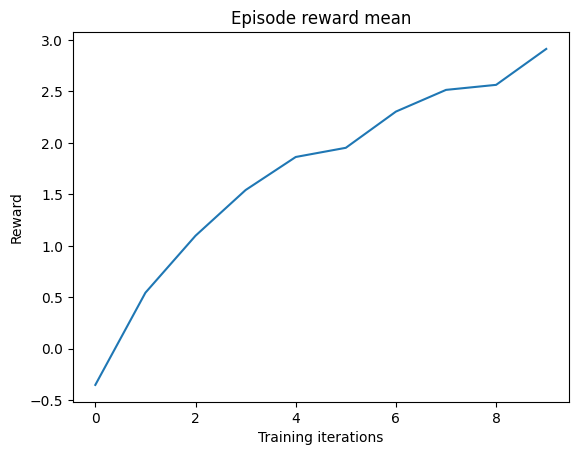

In [15]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

PPO Multi agent

In [22]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.distributions import MultivariateNormal
import numpy as np

%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import json
from typing import Tuple, Optional, Dict
import torch
import gymnasium as gym


from env import MazeEnv

In [23]:
class MemoryBuffer:
    '''Simple buffer to collect experiences and clear after each update.'''
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.state_values = []
    
    def clear_buffer(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.dones[:]
        del self.state_values[:]
    
    def get_ordered_trajectories(self, n_agents=None):
        ordered_actions = torch.FloatTensor()
        ordered_states = torch.FloatTensor()
        ordered_logprobs = torch.FloatTensor()
        ordered_rewards = []
        ordered_dones = []
        
        actions = torch.stack(self.actions)
        states = torch.stack(self.states)
        logprobs = torch.stack(self.logprobs)

        self.ordered_actions = torch.FloatTensor()
        for index in range(actions.shape[1]):
            if n_agents !=None and n_agents == index+1:
                break
            ordered_states = torch.cat((ordered_states, states[:, index]), 0)
            ordered_actions = torch.cat((ordered_actions, actions[:, index]), 0)
            ordered_logprobs = torch.cat((ordered_logprobs, logprobs[:, index]), 0)
            ordered_rewards.extend(np.asarray(self.rewards)[:, index])
            ordered_dones.extend(np.asarray(self.dones)[:, index])

        return ordered_states, ordered_actions, ordered_logprobs, ordered_rewards, ordered_dones

In [24]:
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, action_std=0.5, hidden_size=32, low_policy_weights_init=True):
        super().__init__()

        self.actor_fc1 = nn.Linear(state_size, 2*hidden_size)
        self.actor_fc2 = nn.Linear(2*hidden_size, 2*hidden_size)
        self.actor_fc3 = nn.Linear(2*hidden_size, hidden_size)

        self.actor_mu = nn.Linear(hidden_size, action_size)
        self.actor_sigma = nn.Linear(hidden_size, action_size)
        
        
        self.critic_fc1 = nn.Linear(state_size, 2*hidden_size)
        self.critic_fc2 = nn.Linear(2*hidden_size, 2*hidden_size)
        self.critic_fc3 = nn.Linear(2*hidden_size, hidden_size)

        self.critic_value = nn.Linear(hidden_size, 1)

        self.distribution = torch.distributions.Normal

        self.action_var = torch.full((action_size,), action_std*action_std)
        
        # Boosts training performance in the beginning
        if low_policy_weights_init:
            with torch.no_grad():
                self.actor_mu.weight.mul_(0.01)

    def forward(self, state):
        x = torch.tanh(self.actor_fc1(state))
        x = torch.tanh(self.actor_fc2(x))
        x = torch.tanh(self.actor_fc3(x))
        mu = torch.tanh(self.actor_mu(x))
        sigma = F.softplus(self.actor_sigma(x))

        v = torch.tanh(self.critic_fc1(state))
        v = torch.tanh(self.critic_fc2(v))
        v = torch.tanh(self.critic_fc3(v))
        state_value = self.critic_value(v)

        return mu, sigma, state_value 

    def act(self, state):
        '''Choose action according to the policy.'''
        action_mu, action_sigma, state_value = self.forward(state)

        action_var = self.action_var.expand_as(action_mu)
        cov_mat = torch.diag_embed(action_var)
        dist = MultivariateNormal(action_mu, cov_mat)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        return action.detach(), log_prob.detach()
    
    def evaluateStd(self, state, action):
        '''Evaluate action using learned std value for distribution.'''
        action_mu, action_sigma, state_value = self.forward(state)
        m = self.distribution(action_mu.squeeze(), action_sigma.squeeze())
        log_prob = m.log_prob(action)

        return log_prob, state_value

    def evaluate(self, state, action):
        '''Evaluate action for a given state.'''   
        action_mean, _, state_value = self.forward(state)
        
        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var)
        
        dist = MultivariateNormal(action_mean, cov_mat)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy

In [25]:
class PPO():
    '''Proximal Policy Optimization algorithm.'''
    def __init__(self, state_size, action_size, lr=1e-4, gamma=0.99, epsilon_clip=0.2, epochs=20, action_std=0.5):

        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma  = gamma
        self.epsilon_clip = epsilon_clip
        self.K_epochs = epochs

        self.policy = ActorCritic(self.state_size, self.action_size, action_std, hidden_size=128)
        self.policy_old = ActorCritic(self.state_size, self.action_size, action_std, hidden_size=128)

        self.MseLoss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr, betas=(0.9, 0.999))

        self.episode = 0
    
    def select_action(self, state):
        '''Get action using state in numpy format'''
        # state = torch.FloatTensor(state.reshape(1, -1))
        state = torch.FloatTensor(state)
        
        return self.policy_old.act(state)

    def update(self, memory):
        '''Update agent's network using collected set of experiences.'''
        states, actions, log_probs, rewards, dones = memory.get_ordered_trajectories(5)

        discounted_rewards = []
        discounted_reward = 0
        for i in reversed(range(len(rewards))):
            if dones[i] == True:
                discounted_reward = 0  
            discounted_reward = rewards[i] + self.gamma*discounted_reward
            discounted_rewards.insert(0, discounted_reward)
        
        discounted_rewards = torch.tensor(discounted_rewards)
        # old_state_values = torch.stack(state_values, 1).detach()
        # advantages = discounted_rewards - old_state_values.detach().squeeze()
        # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-5)
        
        # states = torch.squeeze(torch.stack(states), 1).detach()
        # actions = torch.squeeze(torch.stack(actions), 1).detach()
        # old_log_probs = torch.squeeze(torch.stack(log_probs), 1).detach()

        states = states.detach()
        actions = actions.detach()
        old_log_probs = log_probs.detach()


        for epoch in range(self.K_epochs):

            new_log_probs, state_values, dist_entropy = self.policy.evaluate(states, actions)

            new_log_probs = new_log_probs.squeeze()
            advantages = discounted_rewards - state_values.detach().squeeze()
            ratios = torch.exp(new_log_probs - old_log_probs.detach())
            ratios_clipped = torch.clamp(ratios, min=1-self.epsilon_clip, max=1+self.epsilon_clip)
            loss = -torch.min(ratios*advantages, ratios_clipped*advantages)+ 0.5*self.MseLoss(state_values, discounted_rewards) - 0.01*dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

In [29]:
def simulation_config(config_path: str, new_agent: bool = True):
    """
    Configure the environment and optionally an agent using a JSON configuration file.

    Args:
        config_path (str): Path to the configuration JSON file.
        new_agent (bool): Whether to initialize the agent. Defaults to True.

    Returns:
        Tuple[MazeEnv, Optional[MyAgent], Dict]: Configured environment, agent (if new), and the configuration dictionary.
    """
    
    # Read config
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)

    # Env configuration
    env = MazeEnv(
        size=config.get('grid_size'),                               # Grid size
        walls_proportion=config.get('walls_proportion'),            # Walls proportion in the grid
        num_dynamic_obstacles=config.get('num_dynamic_obstacles'),  # Number of dynamic obstacles
        num_agents=config.get('num_agents'),                        # Number of agents
        communication_range=config.get('communication_range'),      # Maximum distance for agent communications
        max_lidar_dist_main=config.get('max_lidar_dist_main'),      # Maximum distance for main LIDAR scan
        max_lidar_dist_second=config.get('max_lidar_dist_second'),  # Maximum distance for secondary LIDAR scan
        max_episode_steps=config.get('max_episode_steps'),          # Number of steps before episode termination
        render_mode=config.get('render_mode', None),
        seed=config.get('seed', None)                               # Seed for reproducibility
    )

    # Agent configuration
    agents = PPO(state_size=env.single_agent_state_size*env.num_agents,action_size=env.num_agents * env.action_space.n) if new_agent else None

    return env, agents, config

In [ ]:
import torch
import numpy as np
from collections import deque
import time
from torch.utils.tensorboard import SummaryWriter


n_agents = 2
n_episodes = 4000
max_steps = 1600
update_interval = 16000/n_agents
log_interval = 10
solving_threshold = 30
time_step = 0

render = False
train = True
pretrained = False
tensorboard_logging = True

env, agent, config = simulation_config('config.json', new_agent=True)

scores = deque(maxlen=log_interval)
max_score = -1000
episode_lengths = deque(maxlen=log_interval)
rewards =  []

memory = MemoryBuffer()

if not train:
    agent.policy_old.eval()
else:
    writer = SummaryWriter(log_dir='logs/'+str(time.time()))

if pretrained:
    agent.policy_old.load_state_dict(torch.load('./_model_best_old.pth'))
    agent.policy.load_state_dict(torch.load('./_model_best_old.pth'))


for n_episode in range(1, n_episodes+1):
    states, env_info = env.reset()
    state = states[0]
    states = torch.FloatTensor(states).view(1, -1)
    # print("States shape: ", states.shape)
    # state = torch.FloatTensor(state.reshape(1, -1))
    episode_length = 0
    episodic_rewards = []
    for t in range(max_steps):
        time_step += 1
        states = torch.FloatTensor(states).flatten() 
        actions, log_probs = agent.select_action(states)
        pi = torch.distributions.Categorical(logits=actions.view(n_agents, -1))
        log_probs = pi.log_prob(torch.tensor(actions))
        prob_agent = actions.view(n_agents, -1)
        
        actions_step = [0]*n_agents
        for i in range(n_agents):
            pi = torch.distributions.Categorical(logits=prob_agent[i])
            actions_step[i] = pi.sample().item()
        memory.actions.append(actions)
        memory.logprobs.append(log_probs)
        memory.states.append(states)
        # echantillonage des actions
        
        
        
        
        # actions = []
        # ## Unity env style
        # for agent_id in range(0,20):
        #     actions.append(action.data.numpy().flatten())

        states, rewards, terminated, truncated, info = env.step(actions_step)         # send all actions to tne environment
        
        # states = env_info.vector_observations         # get next state (for each agent)
        # rewards = env_info.rewards                         # get reward (for each agent)
        # dones = env_info.local_done   
        dones = [terminated]*env.num_agents
        state = states[0]
        reward = rewards[0]
        done = terminated or truncated

        # state, reward, done, _ = env.step(action.data.numpy().flatten())


        memory.rewards.append(rewards)
        memory.dones.append(dones)
        episodic_rewards.append(rewards)
        state_value = 0
        
        # if render:
        #     image = env.render(mode = 'rgb_array')
            # if time_step % 2 == 0:
            #     writerImage.append_data(image)

        if train:
            if time_step % update_interval == 0:
                agent.update(memory)
                time_step = 0
                memory.clear_buffer()

        episode_length = t

        if done:
            break
    
    episode_lengths.append(episode_length)
    total_reward = np.sum(episodic_rewards)/n_agents
    scores.append(total_reward)
    
    if train:
        if n_episode % log_interval == 0:
            print("Episode: ", n_episode, "\t Avg. episode length: ", np.mean(episode_lengths), "\t Avg. score: ", np.mean(scores))

            if np.mean(scores) > solving_threshold:
                print("Environment solved, saving model")
                torch.save(agent.policy_old.state_dict(), 'PPO_model_solved_{}.pth'.format(time.time()))
        
        if n_episode % 100 == 0:
            print("Saving model after ", n_episode, " episodes")
            torch.save(agent.policy_old.state_dict(), '{}_model_{}_episodes.pth'.format(time.time(), n_episode))
            
        if total_reward > max_score:
            print("Saving improved model")
            max_score = total_reward
            torch.save(agent.policy_old.state_dict(), '{}_model_best.pth'.format(time.time()))

        if tensorboard_logging:
            writer.add_scalars('Score', {'Score':total_reward, 'Avg._Score': np.mean(scores)}, n_episode)
            writer.add_scalars('Episode_length', {'Episode_length':episode_length, 'Avg._Episode length': np.mean(episode_lengths)}, n_episode)
    
    else:
        print("Episode: ", n_episode, "\t Episode length: ", episode_length, "\t Score: ", total_reward)
        
    total_reward = 0

WARNING
1 [ 1 14] [array([-1, 14]), array([-1, 14])]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x22 and 44x256)